In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import math

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn')

## Loading data and preprocessing

In [2]:
path = r"/home/dazai/Documents/Processmining/Data/"
df_train = pd.read_csv(f'{path}BPI_Challenge_2012-training.csv')
df_test = pd.read_csv(f'{path}BPI_Challenge_2012-test.csv')


df_data = pd.concat([df_train, df_test])
df_data['event time:timestamp'] = pd.to_datetime(df_data['event time:timestamp'], dayfirst=True)
df_data['case REG_DATE'] = pd.to_datetime(df_data['case REG_DATE'])

df_data.sort_values(by=['event time:timestamp'], inplace=True)
df_data.reset_index(inplace=True, drop=True)

# remove whitespace at beginning and end of column name
df_data.columns = df_data.columns.str.strip(' ')

In [3]:
# df_data = pd.read_pickle('/home/dazai/Documents/Processmining/Data/pickle.pkl')


In [4]:
np.random.seed(41)

df_data = df_data[df_data['case concept:name'].isin(np.random.choice(df_data['case concept:name'].unique(), size=10000, replace=False))]

In [5]:
# Remove timezone information
def remove_timezone(dt):
    return dt.replace(tzinfo=None)

# Calculate time difference since case start
df_data['case REG_DATE'] = df_data['case REG_DATE'].apply(remove_timezone);
df_data['days_since_start'] = df_data['event time:timestamp'] - df_data['case REG_DATE'];
df_data['days_since_start'] = df_data['days_since_start'].dt.days;
df_data = df_data.iloc[:-1];

In [6]:
from sklearn.model_selection import train_test_split

df_data, df_test = train_test_split(df_data, test_size=0.2, shuffle=False)

## Function definitions

In [7]:
import statsmodels.api as sm



def sliding_window(window_size, df):
    """transforms df_data into supervised form 
    with rolling window implementations

    Args:
        window_size (int): size of rolling window

    Returns:
        (X, Y): tuple of input and output arrays
    """

    windows = list(df.rolling(window=window_size))
    for i in windows[window_size-1:]:    
        # split into X and Y
        temp = i.to_numpy()
        temp = [item for sublist in temp for item in sublist]
        Y.append(temp.pop(-1))
        X.append(temp[1:])
    return None


def cross_validate(X, Y):
    """Creates a timesseries split and calculates 
    cross validation error fitted on a given estimator

    Args:
        X (array): input array 
        Y (array): output array

    Returns:
        output, model (tuple): list of true y and predicted + model
    """
    output = []
    ts = TimeSeriesSplit(gap=175, max_train_size=None, n_splits=5, test_size=None)

    for train_index, test_index in ts.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        model = linear_model.LinearRegression().fit(X_train, y_train)
        y_pred = model.predict(X_test)
        output.append((y_test, y_pred))
        
    return output, model

        
    

 

## Encoding

In [8]:
from sklearn.preprocessing import MinMaxScaler

def encode(df):
    scaler = MinMaxScaler()
    scaler.fit(df[['case AMOUNT_REQ']])
    df['case AMOUNT_REQ'] = scaler.transform(df[['case AMOUNT_REQ']])

    # Get dummy variables and encode lifecycle
    df_dummies_lifecycle = pd.get_dummies(df['event lifecycle:transition'], prefix='Lifecycle', drop_first=True)
    df = df.loc[:, df.columns != 'event lifecycle:transition'].copy().join(df_dummies_lifecycle)


    # dummy variables encoded
    df_dummies_name = pd.get_dummies(df['event concept:name'], prefix='Event Name', drop_first=True)
    df.drop('event concept:name', axis=1, inplace=True)
    df = df.join(df_dummies_name)
    return df

## Feature engineering (I think?)

In [9]:
def preprocess(df, log, outliers):
    df = df.copy()
    # Calculate time difference between current and next row
    df['time_diff'] = df['event time:timestamp'].shift(-1);
    df['time_diff'] = df['time_diff'] - df['event time:timestamp'] 
    df['time_diff'] = df['time_diff'].dt.total_seconds();
    # df['time_diff'] = df['time_diff'].round();
    df = df.iloc[:-1];
    
    df = df[df['time_diff']>=0]

    if log == True:
        df['time_diff'] = np.log(df['time_diff'].replace(0, np.nan))
        df['time_diff'] = df['time_diff'].replace(np.nan, 0)
    
    
    # Adding time features
    df['day'] = df['event time:timestamp'].dt.day;
    df['month'] = df['event time:timestamp'].dt.month;
    df['hour'] = df['event time:timestamp'].dt.hour;
    df['day_of_week'] = df['event time:timestamp'].dt.weekday;

    # Cyclical encoding
    df["hour"] = 2 * math.pi * df["hour"] / df["hour"].max()
    df["hour_cos"] = np.cos(df["hour"])
    df["hour_sin"] = np.sin(df["hour"])
    df["day_of_week"] = 2 * math.pi * df["day_of_week"] / df["day_of_week"].max()
    df["day_of_week_cos"] = np.cos(df["day_of_week"])
    df["day_of_week_sin"] = np.sin(df["day_of_week"])

    # drop unnecessary columns
    df.drop(columns=['event time:timestamp', 'eventID', 'case REG_DATE',
                        'day_of_week', 'hour'], inplace=True)

    # put columns in right order
    cols = df.columns.tolist()
    cols.remove('time_diff')
    cols = cols + ['time_diff']
    df = df[cols]

    if outliers == 'capped':
        # Filter outliers
        df.loc[df['time_diff']>600, 'time_diff'] = 601
    elif outliers == 'removed':
        df = df[df['time_diff']<=600]
    elif outliers == 'keep':
        pass
    else:
        print('ERROR')
        
        
    return df
    

In [10]:
df_data = encode(df_data)
df_data = df_data.groupby('case concept:name').apply(lambda x: preprocess(x, log=True, outliers='removed'))
df_data.drop('case concept:name', axis=1, inplace = True)

df_data = df_data[~df_data['hour_cos'].isna()]
df_data = df_data[~df_data['day_of_week_cos'].isna()]

In [11]:
X = []
Y = []
df_data.groupby('case concept:name').apply(lambda x: sliding_window(3, x))
test = cross_validate(np.array(X), np.array(Y))
model = test[1]

In [12]:
test = test[0]
mse = np.mean([mean_squared_error(i[0], i[1]) for i in test])
r2 = np.mean([r2_score(i[0], i[1]) for i in test])
mae = np.mean([mean_absolute_error(i[0], i[1]) for i in test])
rmse = np.mean([mean_squared_error(i[0], i[1], squared=False) for i in test])
# print(f'mse: {math.exp(mse)}\nr^2: {r2}\nrmse: {math.exp(rmse)}\nmae:{math.exp(mae)}')
print(f'mse: {mse}\nr^2: {r2}\nrmse: {rmse}\nmae:{mae}')

mse: 5.30985471795473
r^2: 0.7515943499514596
rmse: 2.3036132000303087
mae:1.6404406368728626


In [13]:
y_true = pd.DataFrame(test[-1][0])
y_pred = pd.DataFrame(test[-1][1])
df_error = pd.concat([y_true, y_pred], axis=1)
df_error.columns = ['y_true', 'y_pred']
df_error.reset_index(inplace=True)
df_error['error'] = df_error['y_true'] - df_error['y_pred']

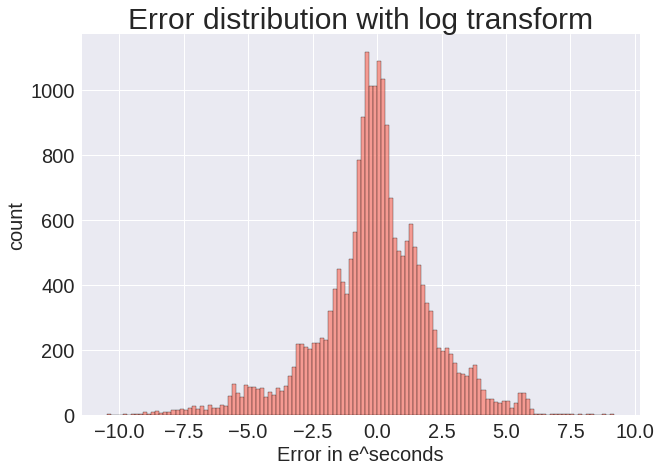

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
# df_error.plot.hist(x='index', y='error', figsize=(10,5), ax=ax, bins=10)
sns.histplot(data=df_error, x='error', ax=ax, color='salmon')
ax.set_title('Error distribution with log transform', size=30)
ax.set_ylabel('count', fontsize=20)
ax.set_xlabel('Error in e^seconds', fontsize=20)
plt.yticks(fontsize=20);
plt.xticks(fontsize=20);

# Test set

In [13]:
df_test = encode(df_test)

df_test = df_test.groupby('case concept:name').apply(lambda x: preprocess(x, log=True, outliers='keep'))
df_test.drop('case concept:name', axis=1, inplace = True)

df_test = df_test[~df_test['hour_cos'].isna()]
df_test = df_test[~df_test['day_of_week_cos'].isna()]

In [14]:
X = []
Y = []
df_test.groupby('case concept:name').apply(lambda x: sliding_window(3, x))
y_pred = model.predict(X)

In [15]:
mse = mean_squared_error(Y, y_pred)
r2 = r2_score(Y, y_pred)
mae = mean_absolute_error(Y,y_pred )
rmse = mean_squared_error(Y, y_pred, squared=False)
print(f'mse: {math.exp(mse)}\nr^2: {r2}\nrmse: {math.exp(rmse)}\nmae:{math.exp(mae)}')




mse: 243.4055022236621
r^2: 0.741717353242444
rmse: 10.423717972966951
mae:5.305118359703051


---

In [18]:
# X = []
# Y = []
# df_data = encode(df_data)
# df_data = preprocess(df_data, log=True, outliers='capped')

# # df_data.groupby('case concept:name').apply(lambda x: sliding_window(3, x))
# sliding_window(3, df_data)
# test = cross_validate(np.array(X), np.array(Y))
# model = test[1]

vif

In [19]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
  

# # the independent variables set
# X = df_data.drop(['time_diff','case concept:name'], axis=1)
  
# # VIF dataframe
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
  
# # calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i)
#                           for i in range(len(X.columns))]
  
# print(vif_data)

In [15]:
# df_error.iloc[:200].plot(
#     kind='scatter',
#     x='index', 
#     y=['y_true', 'y_pred'],
#     backend='plotly', 
#     width=1200,
#     height=800   
# )

In [21]:
# df_error.plot(
#     kind='scatter',
#     x='index', 
#     y=['error'], 
#     backend='plotly', 
#     width=1200,
#     height=800   
# )

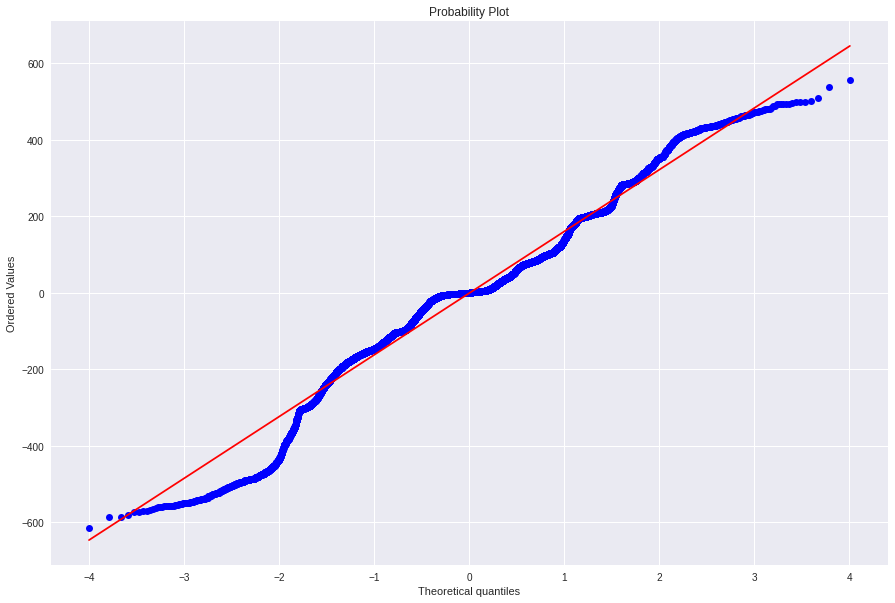

In [38]:
# import scipy.stats as stats
# fig, ax = plt.subplots(figsize=(15,10))
# stats.probplot(df_error['error'], plot=ax);

In [23]:
# fig, ax = plt.subplots(figsize=(20,15))
# df_error.plot(kind='scatter', x='index', y='y_true', color='r', ax=ax)    
# df_error.plot(kind='scatter', x='index', y='y_true', color='g', ax=ax)  
# # ax.scatter(data=df_error, x=df_error.index, y='y_true', color='r');
# # ax.scatter(data=df_error, x=df_error.index, y='y_pred', color='g');

In [24]:
# df_error.plot(kind='scatter', x='index', y='y_true', color='r', ax=ax)    
# df_error.plot(kind='scatter', x='index', y='y_true', color='g', ax=ax)    
# # df_error.plot(kind='scatter', x=df_error['index'], y='y_pred', color='r')    

In [25]:
# df_data.groupby('case concept:name').size().to_frame().describe()